# Introduction:

In this project we have shown:
<br>
- 下载和提取数据集
- 使用transforms加载数据集,并对数据集进行划分
- 计算数据集其均值并进行归一化、可视化
- defining a ResNet model
- defining the ResNet blocks
- loading a pre-trained model
- loading pre-trained model parameters into a defined model
- 定义一个类寻找最优学习率lr
- 进行discriminative fine-tuning（判别微调）
- 使用单周期学习率调度器（One-cycle learning rate schedulers）
- 微调预训练的模型，以实现约80％的TOP-1准确性，并且在数据集中具有200个类别的〜95％的前5个准确性，每个类别只有60个示例
- 查看模型的损失率
- 使用PCA和T-SNE在较低维度中可视化数据
- 查看模型学习到的权重（learned weights）
- 绘制ROC曲线和PR曲线

像VGG一样，Resnet也具有多种配置，可以指定这些层的层数和大小。每一层都是由块制成的，这些块由卷积层，批处理标准化层和残差连接组成。
残差连接只是块的输入与块的输出之间的直接连接。有时残差的连接中有层，但是大多数情况下没有。以下是具有identity残差连接的示例块，即残差路径中没有层。

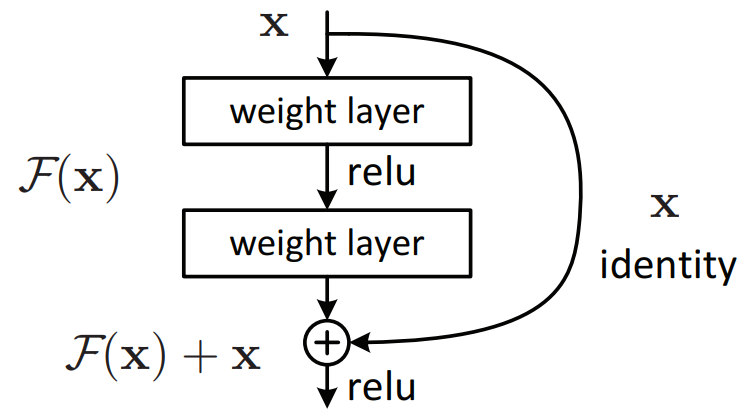

以下是ResNet18, ResNet34, ResNet50, ResNet101 and ResNet152.

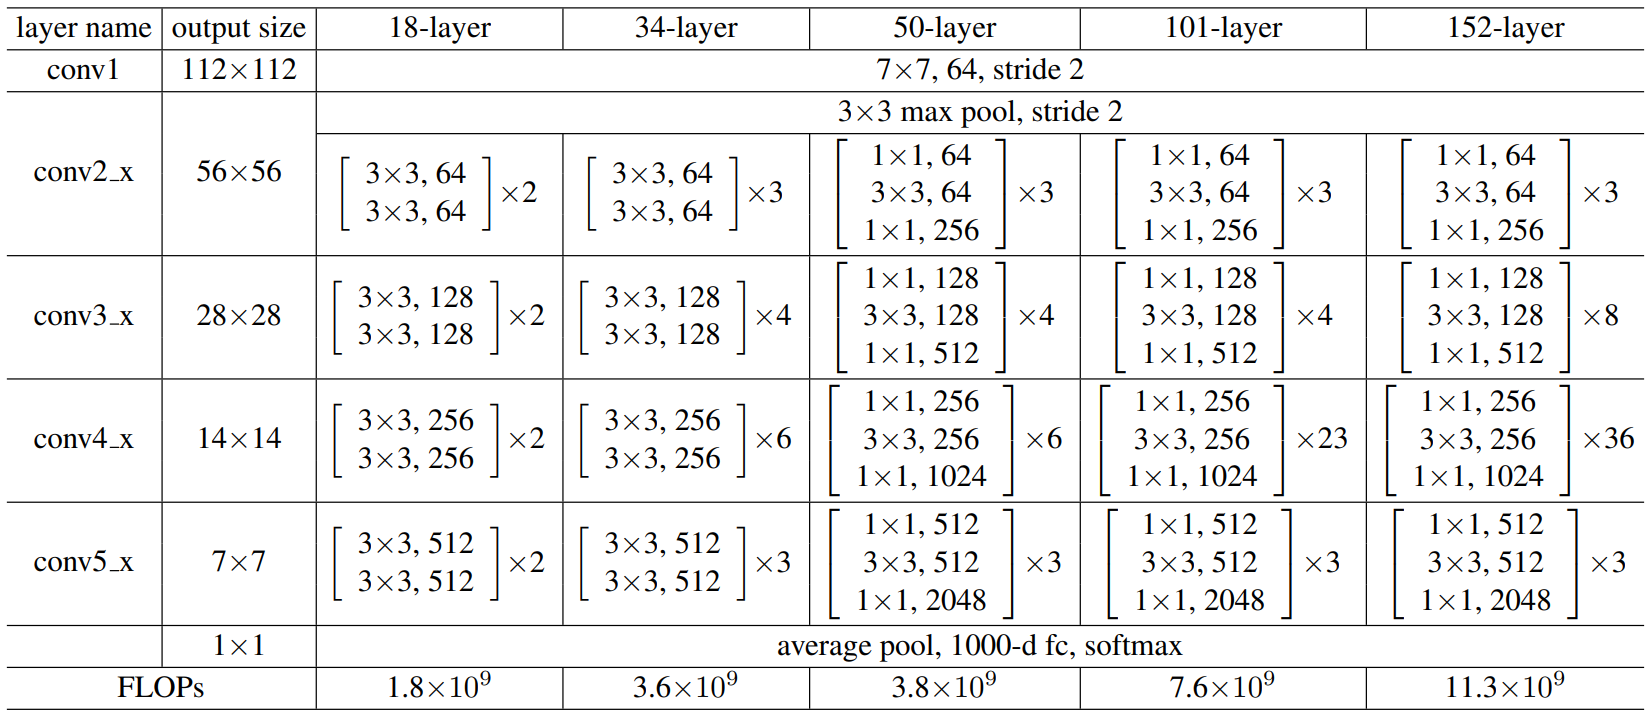

从上表可以看出，对于ResNet18和ResNet34，第一个块包含两个3x3卷积层，共64个过滤器，ResNet18在第一层包含两个block，而ResNet34则包含三个。ResNet50、ResNet101和ResNet152的block的结构不同于ResNet18和ResNet34，这些block称为残差块。残差块减少了输入内部的通道数，然后再扩展回来。
下面是BasicBlock (左)——ResNet18和ResNet34   （右）——ResNet50网络、ResNet101和ResNet 152使用的残差块

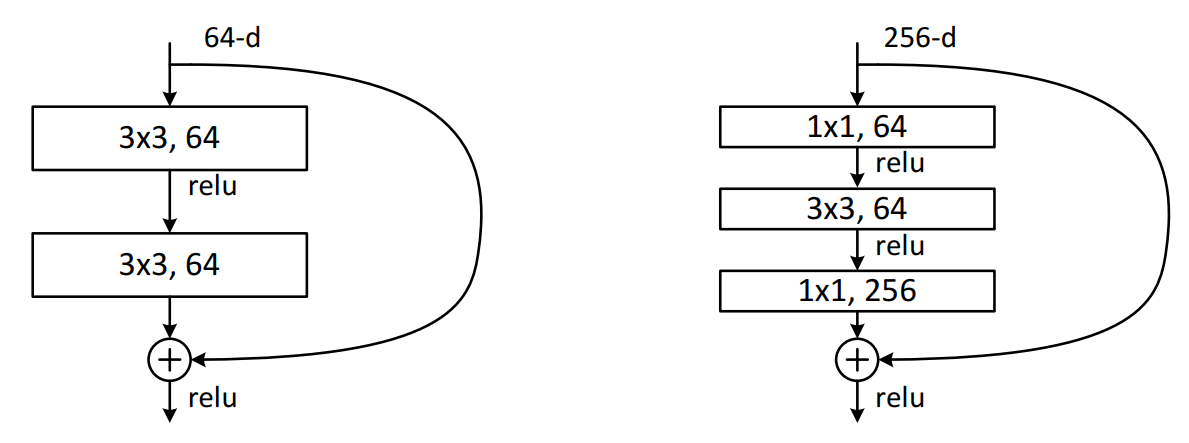

为什么深度残差网络有用?关键在残差连接中，如果只是单纯地把卷积层和池化层进行堆叠，造成的问题就会有梯度消失和梯度爆炸，训练相当深度的神经网络是很困难的。残差连接允许模型学习如何‘跳过’层——通过将它们的所有权值设置为零，只依赖于残差连接。因此，从理论上讲，如果ResNet152模型只使用前52层就可以实际学习输入和输出之间的期望函数，那么剩下的100层应该将它们的权值设置为零，第52层的输出只需通过未受阻碍的残差连接即可。这也使得梯度可以通过那些100层不受阻碍地进行反向传播。
下图显示了VGG-19，无残差连接的卷积神经网络体系结构的比较，以及带有残差连接的RESNET34。

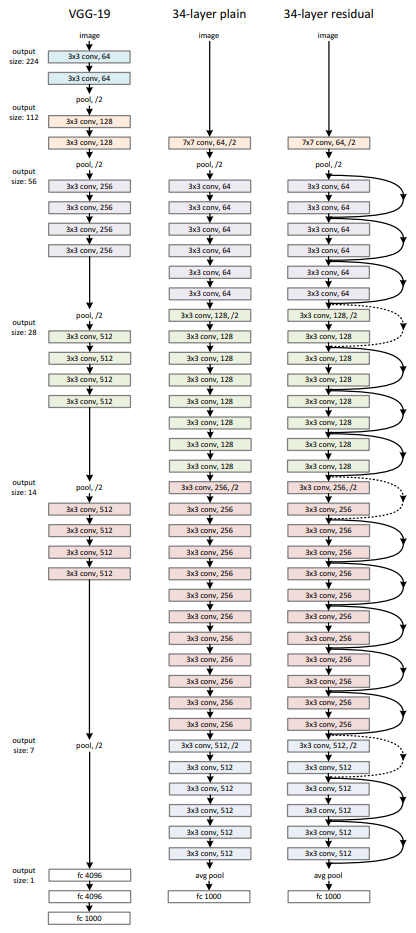

在本项目中，我们使用的是2011版的CUB200数据集。这是一个包含200种不同鸟类的数据集，每个物种有60幅左右的图像，每幅图像在500x500像素左右，我们的目标是正确地对这200个不同鸟类图像进行分类。
数据集地址：http://www.vision.caltech.edu/datasets/cub_200_2011/

接下来先使用训练模型，然后使用fine-tuning进行迁移学习，在学习过程中使用了单周期学习率调度器（One-cycle learning rate schedulers）来进行调优。https://zhuanlan.zhihu.com/p/365873548

## 导入项目所需要的包

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import DataLoader, sampler, random_split

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [ ]:
pip freeze > requirements.txt

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
!/opt/conda/lib/python3.7/site-packages/kaggle

## 获取数据集

In [ ]:
!tar -xzf /kaggle/input/200-bird-species-with-11788-images/CUB_200_2011.tgz

## 划分数据集，对图像进行标准化并可视化

In [ ]:
def get_data_loaders(data_dir, batch_size):
    #对图像数据进行裁剪，剪切，并划分为训练集，验证集，测试集，其中75%为训练集，剩下的25%验证集和测试集各占一半
  transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224), #中心切割
                                transforms.ToTensor()])
  all_data = datasets.ImageFolder(data_dir, transform=transform)
  train_data_len = int(len(all_data)*0.75)
  valid_data_len = int((len(all_data) - train_data_len)/2)
  test_data_len = int(len(all_data) - train_data_len - valid_data_len)
  train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
  return ((train_loader, val_loader, test_loader),train_data, val_data, test_data, all_data.classes)

In [ ]:
(train_loader, val_loader, test_loader),train_data, val_data, test_data, classes = get_data_loaders("CUB_200_2011/images/", 64)

In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

In [ ]:
def normalize_image(image):
    """标准化"""
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [ ]:
def plot_images(images, labels, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = labels[i]
        ax.set_title(label)
        ax.axis('off')

可视化10张图像

In [ ]:
N_IMAGES = 10

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])
plot_images(images, labels)

## Defining the Model

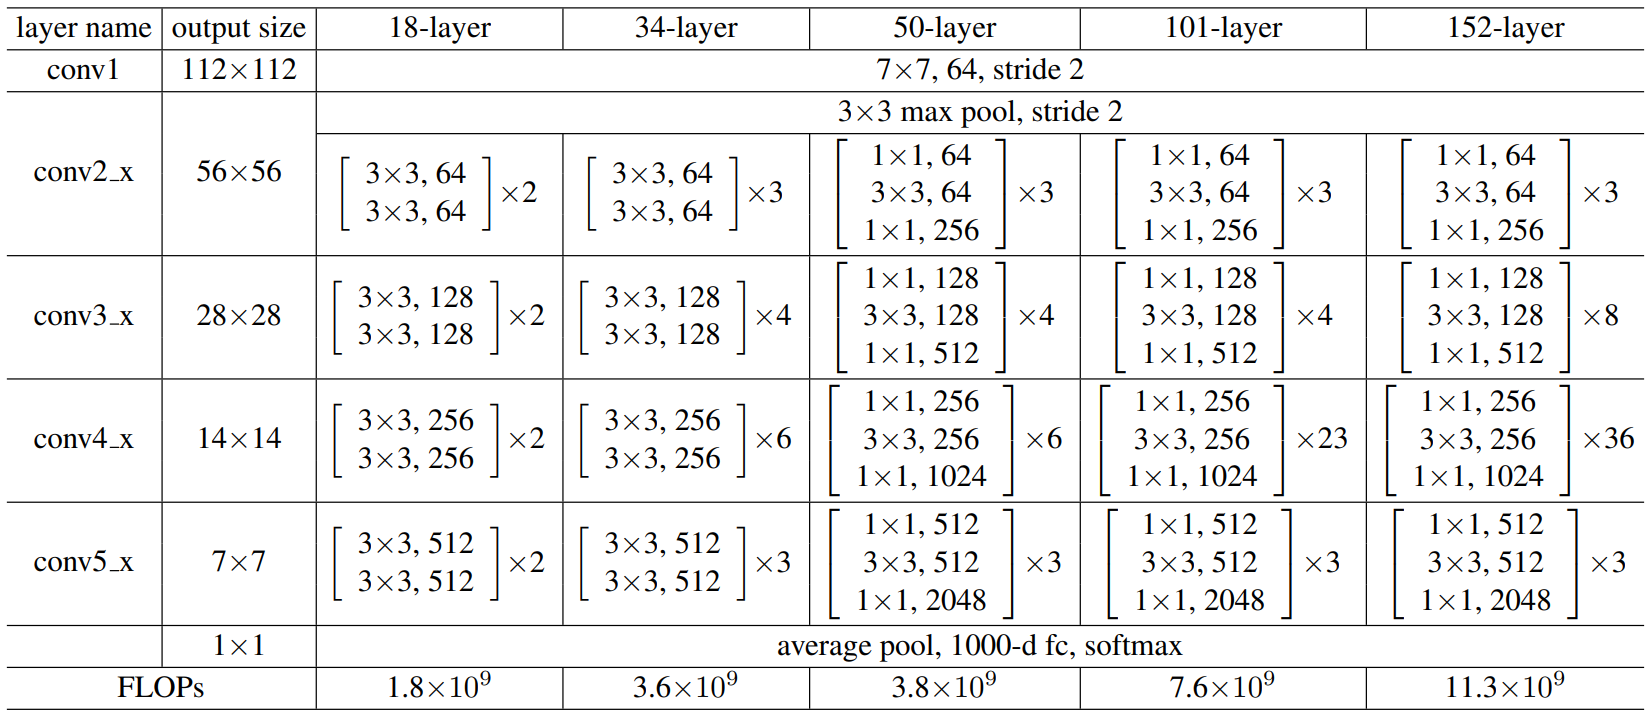

可以看到，在所有Resnet模型的开头，都有一个7x7卷积层和最大池层层，包含padding。随后是四个conv，每个conv都包含不同数量的block。

在ResNet类中定义了初始的7x7卷积层以及批归一化、一个ReLU激活函数和一个降采样max池化层。然后，我们从提供的配置config中构建四个层，其中指定：要使用的块、层中的块数以及该层中的通道数。对于BasicBlock，层中的通道数仅仅是块内两个卷积层的过滤器数。对于残差块，通道数是指前两个卷积层使用的过滤器数——最后一层的过滤器数是通道数乘以一个扩展因子，对于残差块为4。注意，第一层的步幅是1，而最后三层的步幅是2。这个步长只用于改变一个块内第一个卷积层的步长，也用于“降采样”残差路径中——我们将解释深度残差网络中的降采样短期内意味着什么。

ResNet模型最关键的是残差连接。但是，如果在块的主连接中改变图像内部的通道数，那么从残差连接中得到的通道数就不会和图像的通道数相同，因此不能将它们合并在一起。考虑ResNet18第二层的第一个块，传递给它的图像张量将有64个通道，输出将有128个通道。因此，我们需要在64通道张量和128通道张量之间进行残差连接。ResNet模型采用降采样连接来解决这个问题，它并不总是像有时图像的高度和宽度保持不变那样对图像进行降采样，它通过一个卷积层和残差连接增加了图像中的通道数。

因此，为了检查是否需要在块内降采样，我们只需检查块内in_channel的通道数是否为块外的通道数，只检查每一层中的第一个块是否需要下采样。在每一层创建完毕后，当图像被层输出时，在in_channel中更新为图像的通道数。

然后用1x1自适应平均池跟踪4层，对每个通道分别取图像的整个高度和宽度的平均值。如果对平均池的输入为[  512,7,7 ] (512个通道,高7，宽7)，则平均池的输出为[  512,1,1 ]。然后，将这个平均的集合输出传递给线性层来进行预测。当不断更新in_channel以等于每一层输出的图像中的通道数时，也知道第四层之后的图像中的通道数。
需要注意的一点是，初始卷积层的偏置为false，这意味着没有过滤器使用的偏置项。实际上，每个ResNet模型内部使用的每一个卷积层的偏置都为false。ResNet论文作者认为，偏置项是不必要的，因为ResNet中的每一个卷积层都是紧接着的一个批归一化层，它有一个β项，与卷积层中的偏置项作用相同，是一个简单的加法。

In [ ]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
        
        '''
        参数解释
        block: 残差结构的类型
        channels: 残差结构中卷积层所用到卷积核的个数(定义的是第一层卷积核的个数)
        n_blocks： 当前残差层的残差结构的个数
        '''

        '''
        因为Conv_2,Conv_3...都是通过_make_layer函数来生成的，但不是每一层都需要有下采样函数的，也不是每一层的每一个残差结构都需要下采样的函数（也就是带虚线残差结构）的情况有以下几种:
        1. 如果是ResNet中的50,101,152,那么每一个残差层的第一个的残差结构就一定是带虚线的残差结构
        2. 如果是ResNet中的34，那么只有从Conv_3开始的每一个残差层的第一个残差结构才是带虚线的残差结构

        现在用构造ResNet34，ResNet50的构造过程举例说明
        1. ResNet34
        (1)Conv_2：因为此时stride=1,且此时self.in_channel和从外面输入的channel都是64，所以不会生成下采样函数，然后通过if模块的下面那几行代码构建了第一个残差结构，此时传入的stride=1,
        后面是循环，继续构建Conv_2中的其他的残差结构，注意，此时传入的stride也是1，说明没有改变width,height
        (2)Conv_3: 此时的self.in_channel还是64但是外面输入的channel是128了，并且因为传入的stride变成了2，两个条件都满足了所以构造了下采样函数，下采样函数的卷积层的输出是channel*1，
        所以还是128因为此时传入的stride是2，所以下采样函数中也是2，起到将原输入的width和height都降一半的作用，因此在构造主线的第一个残差结构的时候，第一个卷积层的stride是用的2，起到
        缩小shape的作用，第二个卷积层就直接stride=1,维持原样，还要注意构造完第一个残差结构之后，将self.in_channel更新，所以self.in_channel变成了128，然后在构造剩余的残差结构的时候，
        就输入输出都是128，stride默认是1，就一直保持原样。
        (3)Conv_4,Conv_5同理

        2. ResNet50
        (1)Conv_2: 输入的stride=1，但是此时self.in_channel=64,channel=64,block.expansion=4,所以构造了下采样函数，但是因为Conv_2并没有改变input的width和height，所以下采样函数的stride也是1
        在构造第一个残差结构时，第一个卷积层的stride是固定是1的，然后第二个卷积层因为传入的stride还是1所以还是1，第三层卷层的stride还是固定1,构造完第一个残差结构之后，修改self.in_channel=256，
        在构造Conv_2的其他残差结构时，传入默认stride都是1，且每一个残差结构的卷积核的输入输出都是(256,64),(64,64),(64,256)
        (2)Conv_3: 输入的stride=2，且self.in_channel=256,channel=128,block.expansion=4,所以构造输入是256，输出是512，stride=2的卷积层作为下采样，然后在构建第一个残差结构时，主线的第一个卷积层
        的输入是256，输出是128，同时因为stride=1所以shape没变，第二层卷积层输入是128，输出是128，但是因为此时stride的是传入的2，所以shape降为原来的一半，第三层，因为stride=1，shape不变，输入channel
        为128，输出为128*4=512，这样就构造好了第一个残差结构，这一层的其他残差结构就是直接保持shape不变，输入输出channels数依次是(512,128),(128,128),(128,512)。
        (3)Conv_4,Conv_5跟Conv_3同理。
        '''        
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [ ]:
class BasicBlock(nn.Module):
    # 定义的是18层和34层resnet中每一个残差结构(有两层卷积+一个残差)
    expansion = 1# 18层和34层的残差结构中的第一层和第二层的卷积核的个数是一样的(也就是上一层的卷积核的个数(卷积层的输出的feature map个数)==下一层的卷积核的个数(卷积层的输出的feature map个数))
    #expation设为1就是因为在18，34层中每一个卷积层中卷积核的个并没有发生变化
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)# 一个残差结构中的第一个卷积层
        # 当使用的是虚线的残差结构时，传入的stride就会是2,此时这个卷积层起到的作用就是将input的size所谓原来的一半
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        #ReLU激活函数和批归一化
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            #步长为1，不会改变图像的高度和宽度
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x# 先预留输入的特征矩阵
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None: # 如果有下采样，说明是实线残差
            i = self.downsample(i)# 处理输入的特征矩阵
                        
        x += i# 加上初始矩阵
        x = self.relu(x)
        
        return x

In [ ]:
"""
block：ResNet中使用的残差结构类型，如果resnet是18,34层的就使用BasicBlock,50,101,152使用Bottleneck类型
n_blocks：每一个残差层(包含多个残差结构)里边包含的残差结构的个数，然后这个参数是这些个数的列表
channels:通道数
"""
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [ ]:
class Bottleneck(nn.Module):# 定义的50，101，152层resnet中每一个残差结构(有三层卷积+一个残差)
    
    expansion = 4# 同一个残差结构中的第三层的卷积核的个数等于第1,2层的卷积核的个数的4倍
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)# squeeze channels
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)# 这里同理，如果是作为残差层的第一个残差结构，stride=2，从而将input_size缩小为原来的一般
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)# 因为第三层卷积层的输出是输入的4倍# unsqueeze channels
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [ ]:
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

# 加载预训练模型mealv2_resnest50_cutmix
https://blog.csdn.net/weixin_39875760/article/details/110215924?utm_medium=distribute.pc_aggpage_search_result.none-task-blog-2~aggregatepage~first_rank_ecpm_v1~rank_v31_ecpm-6-110215924-null-null.pc_agg_new_rank&utm_term=resnet50%E7%BD%91%E7%BB%9C%E7%BB%93%E6%9E%84%E8%AE%AD%E7%BB%83%E8%BF%87%E7%A8%8B&spm=1000.2123.3001.4430
MEAL在不改变 ResNet-50 网络结构和不使用外部训练数据的前提下，将 ImageNet Top-1 精度提升到 80% 以上的工作，具体而言，MEAL 在每次训练迭代的时候会通过一个 teacher 选择模块随机选择一个teacher产生监督信号，而在 V2 中，这个模块被替换成所有 teacher 的集成，因此每次迭代 student 接收到的监督信号将会更加强大。同时，V2 简化了 V1 里面的中间层 loss，只保留最后一个 KL-loss 和辨别器，使得整个框架变得更加简单，直观和易用。


In [ ]:
# -------迁移学习--------
# pretrained_model = models.resnet50(pretrained = True)
# print(pretrained_model)

!pip install timm
#加载预训练模型 论文：《MEAL V2: Boosting Vanilla ResNet-50 to 80%+ Top-1 Accuracyon ImageNet without Tricks》
pretrained_model = torch.hub.load('szq0214/MEAL-V2','meal_v2', 'mealv2_resnest50_cutmix', pretrained=True)
pretrained_model

In [ ]:
# 这里需要先获取到预训练模型中的最后一个输出的全连接层然后再构建一个全连接层
IN_FEATURES = pretrained_model.module.fc.in_features
OUTPUT_DIM = 200  ## 因为最后只需要划分出200个类别,所以要把原来的全连接层输出改为200

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.module.fc = fc

用自己的随机初始化的线性层替换预训练的模型的线性层。

# tensorboard可视化模型结构

In [ ]:
model = ResNet(resnet50_config, OUTPUT_DIM)
#查看网络结构
import datetime
import tensorflow as tf
# from tensorflow import summary
log_dir="runs/"
 
summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
!./ngrok authtoken 29JwTUcFzjrUXdW4hN7LFYYby2V_dKZvxXMcf7knFEYVZStP

import os
import multiprocessing
 
pool = multiprocessing.Pool(processes = 10)
results_of_processes = [pool.apply_async(os.system, args=(cmd, ), callback = None )
                        for cmd in [
                            f"tensorboard --logdir ./runs/ --load_fast=false --host 0.0.0.0 --port 6006 &",
                            "./ngrok http 6006 &"
                        ]]
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


from torch.utils.tensorboard import SummaryWriter

from torch.autograd import Variable
writer = SummaryWriter()
# 模拟输入数据
input_data = Variable(torch.rand(16, 3, 224, 224))
writer.add_graph(model,input_data)  #
writer.close()

In [ ]:
model.load_state_dict(pretrained_model.module.state_dict())
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

# Training the Model
首先初始化一个学习率很低的优化器Adam，设置交叉熵为损失函数，然后将模型和损失函数放在cuda上。

In [ ]:
START_LR = 1e-7 #定义初始学习率

optimizer = optim.Adam(model.parameters(), lr=START_LR)## 使用Adam作为优化器

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#使用交叉熵
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

编写一个类回调来跟踪与在定义范围内线性变化的学习率相关的损失。

In [ ]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [ ]:
END_LR = 10 #设置最高学习率
#设置迭代次数100
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_loader, END_LR, NUM_ITER)

接下来，可视化在定义范围内的测试结果

In [ ]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    """可视化学习率优化记录"""
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

可以看到学习率为$1x10^{-2}$附近时损失最低

In [ ]:
plot_lr_finder(lrs, losses, skip_start = 10, skip_end = 10)

## 判别微调discriminative fine-tuning
设置模型的学习率：在模型后面的层比前面的层有更高的学习速率。
在最后一层使用找到的学习率作为最大的学习率，而其余各层的学习率较低，逐渐向输入递减。

In [ ]:
FOUND_LR = 1e-3 #设置学习率为刚刚找到的最优学习率

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]#学习率参数字典，传递给模型每一层


optimizer = optim.Adam(params, lr = FOUND_LR) 

# 使用学习率调度器（learning rate scheduler）调节学习率

我们使用的是单周期学习率调度器（One-cycle learning rate schedulers），论文：《Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates》，它从一个小的初始学习速率开始，这个初始学习速率逐渐增加到一个最大值——我们的学习速率查找器找到的值--然后慢慢地将学习速率降低到一个小于初始学习速率的最终值。学习率在每一个参数更新步骤后更新的，即在每一个训练batch后更新。对于我们的模型，最终的fc层在整个训练过程中的学习速率将是类似的：


正如我们所看到的，它从略低于$1x10^{-4}$ 开始逐渐增加到$1x10^{-2}$，然后开始变化到几乎为零。

由优化器不同，用于判别微调的不同参数组合都会有各自的学习速率曲线，各自具有不同的起始和最大值。
假设是学习率增加的初始阶段是一个‘热身’阶段，用来使模型进入一个损失景观普遍较好的区域。曲线的中间，学习速率最大的地方，被认为有利于充当正则化方法，防止模型过拟合或陷入鞍点。最后，采用学习速率降低的“降温”阶段，到达损耗面有较低损耗值的小缝隙。

One-cycle learning rate schedulers也循环了优化器的动量。动量从一个最大值循环到一个最小值，然后回到最大值，在最后几个步骤中它保持恒定。PyTorch的单周期学习速率调度器使用的默认动量最大值和最小值应该足够，因此我们没有对它进行修改。

要设置一个One-cycle learning rate schedulers，我们需要在训练过程中发生的步骤总数，通过将训练迭代器中的epochs与batchs相乘，得到每个参数组合的最大学习率，然后传递给max_lr。
如果只通过一个学习率，而不是一个学习率列表，那么调度器将假定这个学习率用于所有参数，不会做判别微调（discriminative fine-tuning）。

In [ ]:
EPOCHS = 20
STEPS_PER_EPOCH = len(train_loader)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

# 计算top-k精度  https://zhuanlan.zhihu.com/p/340760336?ivk_sa=1024320u

我们的目标是将一幅图像归入200类鸟中的一类，为了在计算准确性时更加宽容，决定使用top-k精度，如果正确的标签在top-k预测中，则预测被标注正确，而不是仅仅是第一个。
为此定义calculate_topk_accuracy函数计算top-1精度以及top-k精度，默认情况下计算的是top-5。

In [ ]:
def calculate_topk_accuracy(y_pred, y, k = 5):
    """计算top-k"""
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].view(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

接下来是进行模型训练，由于学习率调度器一直在进行计算，返回的top-k精度也一直在提高。
并非所有的学习率调度器都需要在每个batch后调用，有的只是在每个epoch后调用。在这种情况下，调度器不需要传递给训练函数，可以在循环中调用。

In [ ]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step() #更新调度器，在优化器之后调用，否则将跳过调度器的第一个学习速率。
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

用top-k作为评价指标。

由于每个参数更新后只能调用一个循环调度器，因此这里不调用它，因为在评估时不更新参数。

In [ ]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# 训练模型，并使用tensorboard可视化训练集上的loss和accuracy，验证集上的loss和accuracy

In [ ]:
best_valid_loss = float('inf')
writer = SummaryWriter()
for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_loader, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, val_loader, criterion, device)
    writer.add_scalar("train_loss",train_loss,epoch+1)
    writer.add_scalar("val_loss",valid_loss,epoch+1)
    writer.add_scalar("train_acc_1",train_acc_1,epoch+1)
    writer.add_scalar("train_acc_5",train_acc_5,epoch+1)
    writer.add_scalar("valid_acc_1",valid_acc_1,epoch+1)
    writer.add_scalar("valid_acc_5",valid_acc_5,epoch+1)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')
writer.close()

In [ ]:
model.load_state_dict(torch.load('tut5-model.pt'))

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_loader, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

# Examining the Model


首先，得到测试集中每个图像的预测结果

In [ ]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_loader)

In [ ]:
pred_labels = torch.argmax(probs, 1)

然后我们用它来绘制混淆矩阵。
由于一个200x200的混淆矩阵相当大，所以我们增加了图形大小并删除色条。文本仍然太小，读不懂，只需关心对角线一般比矩阵的其余部分要暗。
然后，我们可以过滤掉所有正确的预测，然后对错误预测概率排序。
定义一个函数get_representations，得到预测输出，以便执行一些降维操作。

In [ ]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)#预测

            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

In [ ]:
outputs, labels = get_representations(model, train_loader)

由于有200个类，每个类很难用唯一的颜色表示。

同样一个包含200个元素的legend也相当多，所以我们不作图

In [ ]:
# We can then perform PCA on these representations to plot them in two dimensions.

def get_pca(data, n_components = 2):
    pca = decomposition.PCA()  #PCA降维
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [ ]:
def plot_representations(data, labels, n_images = None):
            
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
                
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'hsv')

In [ ]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels)

接下来绘制t-SNE数据，对整个数据集执行t-SNE。
https://zhuanlan.zhihu.com/p/426068503

In [ ]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

从图中可以看到，所有类别都被很好的分开，说明得到了比较好的效果。

In [ ]:
output_tsne_data = get_tsne(outputs)
plot_representations(output_tsne_data, labels)

In [ ]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):
#可视化经过卷积层后的图像
    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image) #标准化

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.7)

可以看出，滤波器执行了许多不同类型的图像处理——从边缘检测到颜色反转。

In [ ]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data #可视化经过第一个卷积层后的几幅图像

plot_filtered_images(images, filters, N_FILTERS)
filters1=model.

In [ ]:
def plot_filters(filters, normalize = True):
    """可视化卷积滤波器"""
    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (30, 15))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')
        
    fig.subplots_adjust(wspace = -0.9)

这些过滤器包含了一些有趣的模式，但所有这些模式都已经存在于预先训练好的ResNet模型中。在这个初始卷积层上使用的学习速率极有可能太小，不能显著改变

In [ ]:
plot_filters(filters)

# 绘制ROC曲线和PR曲线

In [ ]:
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from itertools import cycle
from numpy import interp
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_function = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.002,weight_decay=0.00005,momentum=0.9)

epochs = 10
score_list = []     # 存储预测得分
label_list = []     # 存储真实标签

num_class = 200    # 类别数量
for j in range(epochs):
    model.train()
    for i, (inputs, labels) in enumerate(test_loader):
    #     inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs,_= model(inputs.to(device))
        # prob_tmp = torch.nn.Softmax(dim=1)(outputs) # (batchsize, nclass)
        loss = loss_function(output, labels.to(device))
        loss.backward()
        optimizer.step()
        score_tmp = outputs  # (batchsize, nclass)

        score_list.extend(score_tmp.detach().cpu().numpy())
        label_list.extend(labels.cpu().numpy())

score_array = np.array(score_list)
# 将label转换成onehot形式
label_tensor = torch.tensor(label_list)
label_tensor = label_tensor.reshape((label_tensor.shape[0], 1))
label_onehot = torch.zeros(label_tensor.shape[0], num_class)
label_onehot.scatter_(dim=1, index=label_tensor, value=1)
label_onehot = np.array(label_onehot)

print("score_array:", score_array.shape)  # (batchsize, classnum)
print("label_onehot:", label_onehot.shape)  # torch.Size([batchsize, classnum])

# 调用sklearn库，计算每个类别对应的fpr和tpr
fpr_dict = dict()
tpr_dict = dict()
roc_auc_dict = dict()
for i in range(num_class):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(label_onehot[:, i], score_array[:, i])
    roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
# micro
fpr_dict["micro"], tpr_dict["micro"], _ = roc_curve(label_onehot.ravel(), score_array.ravel())
roc_auc_dict["micro"] = auc(fpr_dict["micro"], tpr_dict["micro"])

# macro
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(num_class)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_class):
    mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])
# Finally average it and compute AUC
mean_tpr /= num_class
fpr_dict["macro"] = all_fpr
tpr_dict["macro"] = mean_tpr
roc_auc_dict["macro"] = auc(fpr_dict["macro"], tpr_dict["macro"])

# 绘制所有类别平均的roc曲线
plt.figure()
lw = 2
plt.plot(fpr_dict["micro"], tpr_dict["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_dict["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr_dict["macro"], tpr_dict["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_dict["macro"]),
         color='navy', linestyle=':', linewidth=4)

# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(num_class), colors):
#     plt.plot(fpr_dict[i], tpr_dict[i], color=color, lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#                    ''.format(i, roc_auc_dict[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig('set200_roc.jpg')
plt.show()

# 绘制PR曲线

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.00005)
for j in range(epochs):
    model.train()
    for i, (inputs, labels) in enumerate(test_loader):
    #     inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs,_= model(inputs.to(device))
        # prob_tmp = torch.nn.Softmax(dim=1)(outputs) # (batchsize, nclass)
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        score_tmp = outputs  # (batchsize, nclass)

        score_list.extend(score_tmp.detach().cpu().numpy())
        label_list.extend(labels.cpu().numpy())

score_array = np.array(score_list)
# 将label转换成onehot形式
label_tensor = torch.tensor(label_list)
label_tensor = label_tensor.reshape((label_tensor.shape[0], 1))
label_onehot = torch.zeros(label_tensor.shape[0], num_class)
label_onehot.scatter_(dim=1, index=label_tensor, value=1)
label_onehot = np.array(label_onehot)

print("score_array:", score_array.shape)  # (batchsize, classnum)
print("label_onehot:", label_onehot.shape)  # torch.Size([batchsize, classnum])

# 调用sklearn库，计算每个类别对应的precision和recall
precision_dict = dict()
recall_dict = dict()
average_precision_dict = dict()
for i in range(num_class):
    precision_dict[i], recall_dict[i], _ = precision_recall_curve(label_onehot[:, i], score_array[:, i])
    average_precision_dict[i] = average_precision_score(label_onehot[:, i], score_array[:, i])
#     print(precision_dict[i].shape, recall_dict[i].shape, average_precision_dict[i])

# micro
precision_dict["micro"], recall_dict["micro"], _ = precision_recall_curve(label_onehot.ravel(),
                                                                          score_array.ravel())
average_precision_dict["micro"] = average_precision_score(label_onehot, score_array, average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision_dict["micro"]))

# # 绘制所有类别平均的pr曲线
plt.figure()
plt.step(recall_dict['micro'], precision_dict['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision_dict["micro"]))
plt.savefig("set200_pr_curve.jpg")
plt.show()

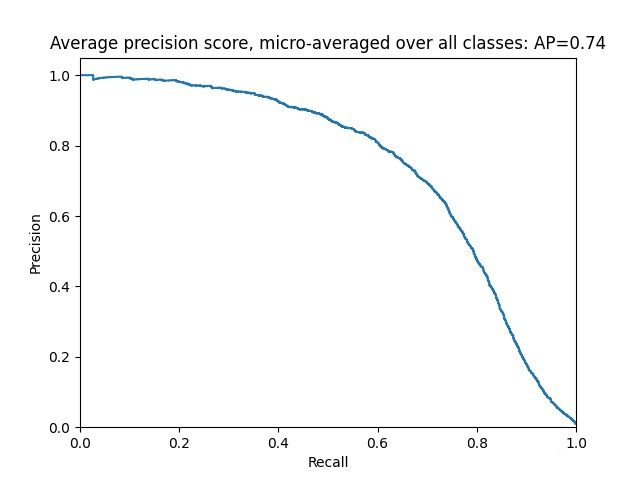

## 评价指标
1. 整体准确率（Total Accuracy）
2. 混淆矩阵（Confusion Matrix）
3. 准确率（Accuracy）
4. 精确率（Precision）
5. 召回率（Recall）
6. F1 Score

## 整体准确率（Total Accuracy）

In [ ]:
def cal_total_accuracy(model, data_loader, device, top_k=1):
    model.eval()

    corrects = 0
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            y_pred, _ = model(X)
            _, top_pred = y_pred.topk(top_k, dim=1)
            top_pred = top_pred.t()
            y_reshape = y.view(1, -1).expand_as(top_pred)
            correct = (top_pred == y_reshape)
            correct_k = correct[:top_k].contiguous().view(-1).float().sum(0)
            corrects += correct_k
    acc_k = corrects.double() / len(data_loader.dataset)

    return acc_k

In [ ]:
# acc_1 = cal_total_accuracy(model, test_loader, device, top_k=1)
# acc_5 = cal_total_accuracy(model, test_loader, device, top_k=5)
# print(f"Acc-1: {acc_1*100:6.2f}%")
# print(f"Acc-5: {acc_5*100:6.2f}%")

#### 混淆矩阵（Confusion Matrix）
计算混淆矩阵，后面会多次用到

In [ ]:
from sklearn.metrics import confusion_matrix


def cal_confusion_matrix(model, data_loader, device):
    model.eval()

    pred_list = torch.zeros(0, dtype=torch.long, device="cpu")
    lbl_list = torch.zeros(0, dtype=torch.long, device="cpu")

    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            y_pred, _ = model(X)
            y_prob = F.softmax(y_pred, dim=-1)
            preds = y_prob.argmax(1, keepdim=True)

            pred_list = torch.cat([pred_list, preds.view(-1).cpu()])
            lbl_list = torch.cat([lbl_list, y.view(-1).cpu()])

    cm = confusion_matrix(lbl_list.numpy(), pred_list.numpy())
    # print(cm)

    return cm

In [ ]:
confusion_mat = cal_confusion_matrix(model, test_loader, device)

In [1]:
def draw_confusion_matrix(cm, num_classes, step=10):
    #绘制混淆矩阵
    cm = cm.astype("float") / cm.sum(1)[:, np.newaxis]
    plt.figure(figsize=(30, 30), dpi=80)
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xticks(np.arange(0, num_classes, step=step), rotation=90)
    plt.yticks(np.arange(0, num_classes, step=step))
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

In [ ]:
draw_confusion_matrix(confusion_mat, 200, 10)

In [ ]:
# 辅助函数，用于后面格式化打印计算结果

def fmt_print_results(title, results):
    print(f"{title} per class:")
    for i, res in enumerate(results):
        print(f"[{i:03d}]: {res*100:6.2f}%, ", end="")
        if i % 5 == 4:
            print("")

## 准确率（Accuracy）

In [ ]:
def cal_class_accuracy(cm):
    class_accuracy = cm.diagonal() / cm.sum(1)
    return class_accuracy

In [ ]:
cls_acc = cal_class_accuracy(confusion_mat)
fmt_print_results("Accuracy", cls_acc)

## 精确率（precision）

In [ ]:
def cal_class_precision(cm):
    num_classes = cm.shape[0]
    class_precision = []
    for i in range(num_classes):
        TP = cm[i][i]
        TP_plus_FP = cm[:, i].sum(0)
        precision = TP / TP_plus_FP
        class_precision.append(precision)
    class_precision = np.array(class_precision)
    return class_precision

## F1 Score

In [ ]:
def cal_class_f1_score(cm):
    num_classes = cm.shape[0]
    class_f1_score = []
    for i in range(num_classes):
        TP = cm[i][i]
        TP_plus_FP = cm[:, i].sum(0)
        TP_plus_FN = cm[i].sum()
        precision = TP / TP_plus_FP
        recall = TP / TP_plus_FN
        f1_score_ = 2 * precision * recall / (precision + recall)
        class_f1_score.append(f1_score_)
    class_f1_score = np.array(class_f1_score)
    return class_f1_score

In [ ]:
cls_f1_score = cal_class_f1_score(confusion_mat)
fmt_print_results("F1 Score", cls_f1_score)

In [ ]:
# from tqdm import tqdm
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# loss_function = nn.CrossEntropyLoss().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.002,weight_decay=0.00005,momentum=0.9)

# epochs = 10
# best_acc = 0.0
# save_path = './resNet50.pth'
# train_steps = len(train_loader)
# val_accuracy_list = []
# train_accuracy_list=[]
# epochs_list = []
# train_loss_list = []
# val_loss_list = []

# for epoch in range(epochs):
#     # train
#     model.train()
# #     if(epoch==20):
# #         optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.00005,momentum=0.9)
# #     elif(epoch==30):
# #         optimizer = optim.Adam(model.parameters(), lr=0.0005,weight_decay=0.00005,momentum=0.9)
# #     elif(epoch==50):
# #         optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay=0.00005,momentum=0.9)

#     train_bar = tqdm(train_loader)
#     for step, data in enumerate(train_bar):
#         images, labels = data
#         optimizer.zero_grad()
#         logits,_ = model(images.to(device))
# #         print(logits)
#         loss = loss_function(logits, labels.to(device))
#         loss.backward()
#         optimizer.step()
#         train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,epochs,loss)

#     # validate
#     model.eval()
#     val_acc = 0.0  # 累计验证集中的所有正确答对的个数
#     train_acc=0.0  # 累计训练集中所有正确答对的个数
#     val_loss = 0.0 # 累计验证集中所有误差
#     train_loss=0.0 # 累积训练集中所有误差
#     with torch.no_grad():
#         val_bar = tqdm(val_loader)
#         for train_data in train_bar:
#             train_images,train_labels=train_data
#             train_outputs,_=model(train_images.to(device))
#             tmp_train_loss=loss_function(train_outputs,train_labels.to(device))
#             train_predict=torch.max(train_outputs,dim=1)[1]
#             train_acc+=torch.eq(train_predict, train_labels.to(device)).sum().item()
#             train_loss+=tmp_train_loss.item()
#             train_bar.desc = "valid in train_dataset epoch[{}/{}]".format(epoch + 1,epochs)

#         for val_data in val_bar:
#             val_images, val_labels = val_data
#             val_outputs,_ = model(val_images.to(device))
#             tmp_val_loss = loss_function(val_outputs, val_labels.to(device))
#             val_predict = torch.max(val_outputs, dim=1)[1]
#             val_acc += torch.eq(val_predict, val_labels.to(device)).sum().item()
#             val_loss+=tmp_val_loss.item()
#             val_bar.desc = "valid in val_dataset epoch[{}/{}]".format(epoch + 1,epochs)
# #8841 1474 1474
#     train_num=8841
#     val_num=1474
#     train_accurate=train_acc/train_num
#     val_accurate = val_acc / val_num
#     train_loss=train_loss / train_num
#     val_loss=val_loss/val_num
#     writer.add_scalar("train_acc",train_accurate,epoch)  #可视化训练正确率
    
#     if(val_accurate>best_acc):
#         best_acc=val_accurate
#     print('[epoch %d] train_loss: %.3f train_acc: %.3f val_loss:%.3f val_acc: %.3f'
#     %(epoch + 1, train_loss , train_accurate, val_loss, val_accurate))
        
#     # 构造各个参数的列表，准备画图
#     val_accuracy_list.append(val_accurate)
#     train_accuracy_list.append(train_accurate)
#     train_loss_list.append(train_loss / train_num)
#     val_loss_list.append(val_loss/ val_num )
#     epochs_list.append(epoch+1)
#     torch.save(model.state_dict(), save_path) # 保存模型

#     # train_acc && val_loss
#     plt.figure()
#     plt.plot(epochs_list,val_accuracy_list,color="red",label="val_acc")
#     plt.plot(epochs_list,train_accuracy_list,color="green",label="train_acc")
#     plt.xlabel("epochs")
#     plt.ylabel("Acc")
#     plt.title('ResNet50 in CUB200')
#     plt.xticks([i for i in range(0,len(epochs_list),20)])
#     acc_gap=[i*0.2 for i in range(0,min(int(len(epochs_list)/2+1),6))]
#     acc_gap.append(max(val_accuracy_list))
#     acc_gap.append(max(train_accuracy_list))
#     plt.yticks(acc_gap)
#     plt.grid()
#     plt.legend()
#     plt.savefig("Acc.jpg")

#     # train_loss && val_loss
#     plt.figure()
#     plt.plot(epochs_list,train_loss_list,color="red",label="train_loss")
#     plt.plot(epochs_list,val_loss_list,color="green",label="val_loss")
#     plt.xlabel('epochs')
#     plt.ylabel('Loss')
#     plt.title('ResNet50 in CUB200')
#     plt.xticks([i for i in range(0,len(epochs_list),20)])
#     plt.grid()
#     plt.legend()
#     plt.savefig("Loss.jpg")

# print('Finished Training')
# print("the best val_accuracy is : {}".format(best_acc))
